# Big Game, Big Data - Part 2: Which Team Will Reign Supreme?

### A Project by Noel McCann

<img src="Images/Part_2_cover.jpg" style="width:640px;height:360px;">

**Purpose of Analysis:**  
In Part 1, we analyzed the play distributions and tackling efficiency of the four teams that remained in the NFL playoffs: the Baltimore Ravens, Detroit Lions,  Kansas City Chiefs, and San Francisco 49ers. As most know at this point, the 49ers and the Chiefs won their respective games, and are heading to Las Vegas for Super Bowl 58. 

But which team will win the Lombardi Trophy and which one will go home empty-handed? For Part 2, we will delve deep into the two finalists. We'll look into the defenders-in-the-box performance for each team and the importance of tackle factor statistics. We'll then analyze the final score averages (away for the 49ers, home for the Chiefs) to help us understand who has the edge. 


## This project will:

- Evaluate the Chiefs and the 49ers on their ability to make tackles when the defenders are close to the line of scrimmage.
- Analyze the tackle factor performance for defenders to determine its importance.
- Calculate the averages to create a prediction for Super Bowl 58.


### Data Importing & Cleaning

Let's get started by getting our libraries set up. We'll first import everything we need to analyze the data.

In [4]:
import gc
import os
import numpy as np # linear algebra
import pandas as pd # data processing & CSV file previews (e.g. pd.read_csv)
import datetime as dt # for accurate times
import matplotlib.pyplot as plt # to create graphs
import matplotlib.cm as cm
import seaborn as sns
from scipy.spatial.distance import cdist
from tqdm.notebook import tqdm

import plotly.graph_objects as go
from plotly.subplots import make_subplots
import plotly.express as px
import plotly.offline

from colorama import Fore, Style, init
from pprint import pprint

import warnings
warnings.filterwarnings('ignore')

With everything we need to run our analysis, let's load each of the base tables provided by the NFL for their 2024 Big Data Bowl competition on Kaggle. For an overview of the tables' contents, [view Part 1 here](https://github.com/nlmccann1991/nfl_big_data_part_1).

In [5]:
games=pd.read_csv('games.csv')
players=pd.read_csv('players.csv')
tackles=pd.read_csv('tackles.csv')
plays=pd.read_csv('plays.csv')
tracking_1=pd.read_csv('tracking_week_1.csv')

We will now clean up our data to enable analyses that are more accurate and simpler to understand, summarizing the data frame feature to use common values.

In [6]:
def summarize_dataframe(df):
    summary_df = pd.DataFrame(df.dtypes, columns=['dtypes'])
    summary_df['missing#'] = df.isna().sum().values*100
    summary_df['missing%'] = (df.isna().sum().values*100)/len(df)
    summary_df['uniques'] = df.nunique().values
    summary_df['first_value'] = df.iloc[0].values
    summary_df['last_value'] = df.iloc[len(df)-1].values
    summary_df['count'] = df.count().values
    #sum['skew'] = df.skew().values
    desc = pd.DataFrame(df.describe().T)
    summary_df['min'] = desc['min']
    summary_df['max'] = desc['max']
    summary_df['mean'] = desc['mean']
    return summary_df


## Team & Player Performance 

### Defending In The Box

For Part 2, we will begin by looking into the understanding of how teams make their tackles with defenders in the box. The term "in the box" is how many defenders are employed in an area close enough to the line of scrimmage where they can directly impact a rushing attempt by the offense. This metric is especially important for teams that tend to use running plays, traditional and otherwise. 

Let's first get all the information we need to determine this metric:

In [20]:
agg_dict_1 = {
    "tackles": pd.NamedAgg(column='tackle', aggfunc='sum'),
    "assists": pd.NamedAgg(column='assist', aggfunc='sum'),
    "forced_fumbles": pd.NamedAgg(column='forcedFumble', aggfunc='sum'),
    "missed_tackles": pd.NamedAgg(column='pff_missedTackle', aggfunc='sum'),
}

play_tackle_df = tackles.groupby(["gameId", "playId"]).agg(**agg_dict_1).reset_index()


play_tackles = pd.merge(
    plays,
    play_tackle_df,
    how="outer",
    on=["gameId", "playId"]
)

play_tackles.head().style.set_caption("Sample of the Play data with tackle stats"). \
set_properties(**{'border': '1.3px solid blue',
                          'color': 'grey'})

,gameId,playId,ballCarrierId,ballCarrierDisplayName,playDescription,quarter,down,yardsToGo,possessionTeam,defensiveTeam,yardlineSide,yardlineNumber,gameClock,preSnapHomeScore,preSnapVisitorScore,passResult,passLength,penaltyYards,prePenaltyPlayResult,playResult,playNullifiedByPenalty,absoluteYardlineNumber,offenseFormation,defendersInTheBox,passProbability,preSnapHomeTeamWinProbability,preSnapVisitorTeamWinProbability,homeTeamWinProbabilityAdded,visitorTeamWinProbilityAdded,expectedPoints,expectedPointsAdded,foulName1,foulName2,foulNFLId1,foulNFLId2,tackles,assists,forced_fumbles,missed_tackles
0,2022100908,3537,48723,Parker Hesse,(7:52) (Shotgun) M.Mariota pass short middle to P.Hesse to 50 for 9 yards (K.Neal).,4,1,10,ATL,TB,ATL,41,7:52,21,7,C,6.000000,nan,9,9,N,69,SHOTGUN,7.000000,0.747284,0.976785,0.023215,-0.006110,0.006110,2.360609,0.981955,nan,nan,nan,nan,1.000000,0.000000,0.000000,0.000000
1,2022091103,3126,52457,Chase Claypool,(7:38) (Shotgun) C.Claypool right end to PIT 37 for 3 yards (C.Awuzie).,4,1,10,PIT,CIN,PIT,34,7:38,14,20,nan,nan,nan,3,3,N,76,SHOTGUN,7.000000,0.416454,0.160485,0.839515,-0.010865,0.010865,1.733344,-0.263424,nan,nan,nan,nan,1.000000,0.000000,0.000000,1.000000
2,2022091111,1148,42547,Darren Waller,(8:57) D.Carr pass short middle to D.Waller to LV 45 for 15 yards (N.Adderley).,2,2,5,LV,LAC,LV,30,8:57,10,3,C,11.000000,nan,15,15,N,40,I_FORM,6.000000,0.267933,0.756661,0.243339,-0.037409,0.037409,1.312855,1.133666,nan,nan,nan,nan,1.000000,0.000000,0.000000,0.000000
3,2022100212,2007,46461,Mike Boone,(13:12) M.Boone left tackle to DEN 44 for 7 yards (J.Abram; D.Deablo).,3,2,10,DEN,LV,DEN,37,13:12,19,16,nan,nan,nan,7,7,N,47,SINGLEBACK,6.000000,0.592704,0.620552,0.379448,-0.002451,0.002451,1.641006,-0.043580,nan,nan,nan,nan,0.000000,2.000000,0.000000,2.000000
4,2022091900,1372,47857,Devin Singletary,(8:33) D.Singletary right guard to TEN 32 for 3 yards (N.Jones; O.Adeniyi). TEN-O.Adeniyi was injured during the play. His return is Questionable. O.Adeniyi walks off.,2,1,10,BUF,TEN,TEN,35,8:33,7,7,nan,nan,nan,3,3,N,75,I_FORM,7.000000,0.470508,0.836290,0.163710,0.001053,-0.001053,3.686428,-0.167903,nan,nan,nan,nan,0.000000,2.000000,0.000000,1.000000


Here is the resulting dataframe from which we will do our analysis from:

In [21]:
play_tackles.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12486 entries, 0 to 12485
Data columns (total 39 columns):
 #   Column                            Non-Null Count  Dtype  
---  ------                            --------------  -----  
 0   gameId                            12486 non-null  int64  
 1   playId                            12486 non-null  int64  
 2   ballCarrierId                     12486 non-null  int64  
 3   ballCarrierDisplayName            12486 non-null  object 
 4   playDescription                   12486 non-null  object 
 5   quarter                           12486 non-null  int64  
 6   down                              12486 non-null  int64  
 7   yardsToGo                         12486 non-null  int64  
 8   possessionTeam                    12486 non-null  object 
 9   defensiveTeam                     12486 non-null  object 
 10  yardlineSide                      12319 non-null  object 
 11  yardlineNumber                    12486 non-null  int64  
 12  game

Of `12070` plays, `12025` contain the tackle-related information and `1344` feature either the 49ers or the Chiefs. The other `460` plays contain missing values, meaning there were no tackle-related events (tackles, missed tackles, assists, or forced fumbles) in such plays.

We'll fill in the games by using a fake constant `-1` to differentiate such plays from those with tackle-related events.

In [22]:
values = {"tackles": -1.0, "assists": -1.0, "forced_fumbles": -1.0, "missed_tackles": -1.0}
play_tackles = play_tackles.fillna(value=values)

play_tackles = play_tackles.astype({"tackles":'int', "assists":'int', 
                                    "forced_fumbles":'int', "missed_tackles":'int',}) 

play_tackles.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12486 entries, 0 to 12485
Data columns (total 39 columns):
 #   Column                            Non-Null Count  Dtype  
---  ------                            --------------  -----  
 0   gameId                            12486 non-null  int64  
 1   playId                            12486 non-null  int64  
 2   ballCarrierId                     12486 non-null  int64  
 3   ballCarrierDisplayName            12486 non-null  object 
 4   playDescription                   12486 non-null  object 
 5   quarter                           12486 non-null  int64  
 6   down                              12486 non-null  int64  
 7   yardsToGo                         12486 non-null  int64  
 8   possessionTeam                    12486 non-null  object 
 9   defensiveTeam                     12486 non-null  object 
 10  yardlineSide                      12319 non-null  object 
 11  yardlineNumber                    12486 non-null  int64  
 12  game

With the data preprocessed, let's now look into the distribution of data featuring defenders in the box, starting with the 49ers. 

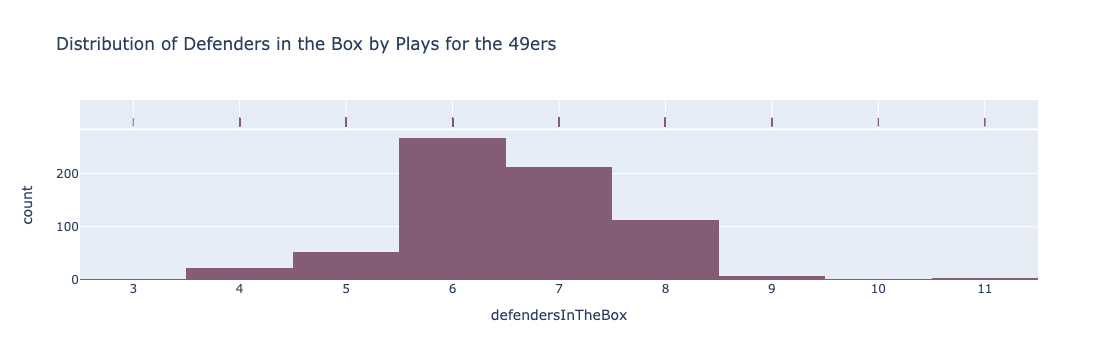

In [23]:
sf_play_tackles = play_tackles[(play_tackles['possessionTeam'] == 'SF') | (play_tackles['defensiveTeam'] == 'SF')]

# Create the histogram for the filtered data
fig = px.histogram(sf_play_tackles, x="defendersInTheBox", marginal="rug",
                   title='Distribution of Defenders in the Box by Plays for the 49ers',
                   color_discrete_sequence=px.colors.qualitative.Antique)

# Display the figure
fig.show()

We can see its distribution to be slightly skewed to the right (with the majority of the plays having it equal to `6` or `7`). With `6` serving as the median for all plays, what about for plays with successful tackles? Let's develop two charts that will illustrate the distribution of defenders near the line of scrimmage for all plays and then those with successful tackles.

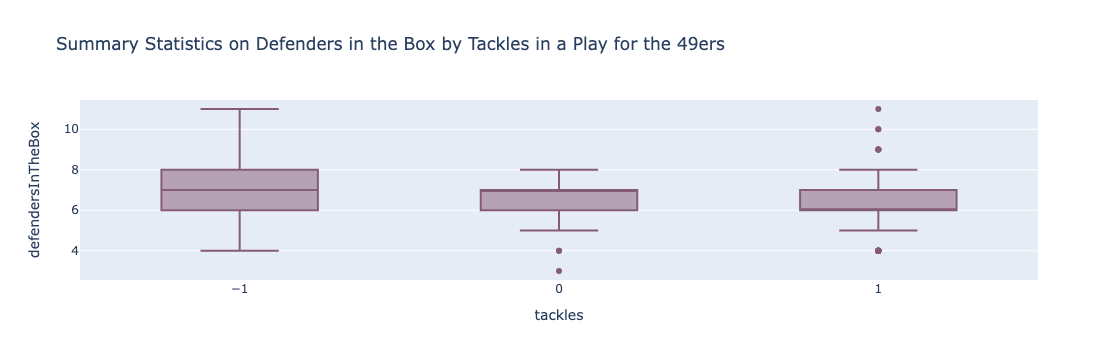

In [24]:
# Filter for plays involving the 49ers as either the possession or defensive team
sf_play_tackles = play_tackles[(play_tackles['possessionTeam'] == 'SF') | (play_tackles['defensiveTeam'] == 'SF')]

# Create the box plot for the filtered data
fig = px.box(sf_play_tackles, x="tackles", y="defendersInTheBox",
             title='Summary Statistics on Defenders in the Box by Tackles in a Play for the 49ers',
             color_discrete_sequence=px.colors.qualitative.Antique)

# Display the figure
fig.show()

For plays with and without successful tackles involving the 49ers, we see a difference in the median. Plays without a tackle made saw a median of `7`, but those with tackles saw a median of `6`. This suggests that for the 49ers, less players in the box can be better for tackle success. 

Let's take a look at the Chiefs now. 

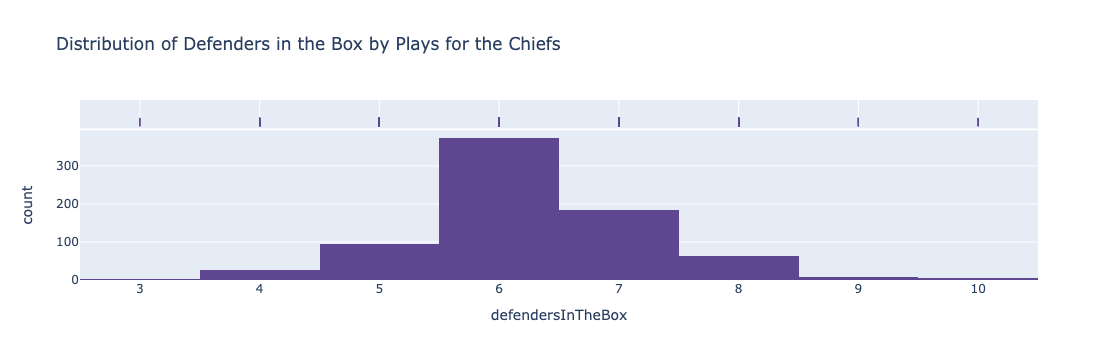

In [25]:
sf_play_tackles = play_tackles[(play_tackles['possessionTeam'] == 'KC') | (play_tackles['defensiveTeam'] == 'KC')]

# Create the histogram for the filtered data
fig = px.histogram(sf_play_tackles, x="defendersInTheBox", marginal="rug",
                   title='Distribution of Defenders in the Box by Plays for the Chiefs',
                   color_discrete_sequence=px.colors.qualitative.Prism)

# Display the figure
fig.show()

We can see its distribution to be more equal (with the majority of the plays having it equal to `6`). Significantly more plays involving the Chiefs have `6` defenders in the box than those for the 49ers. Let's now see if this changes for plays with successful tackles? Let's develop two charts that will illustrate the distribution of defenders near the line of scrimmage for all plays and then those with successful tackles.

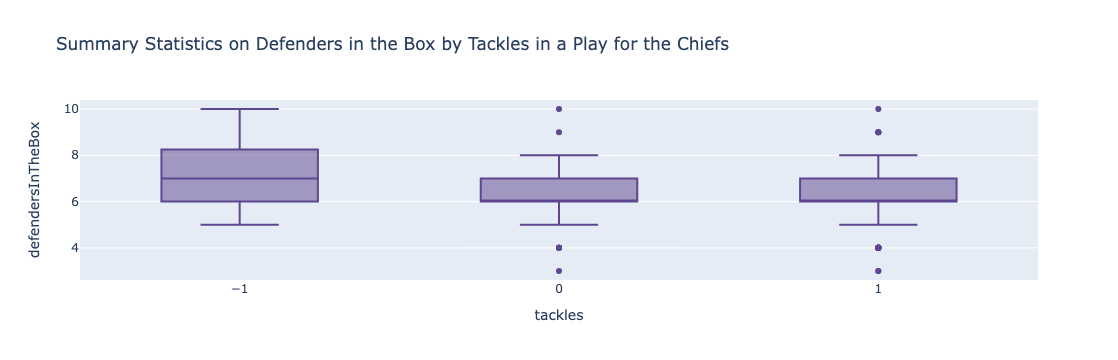

In [26]:
# Filter for plays involving the 49ers as either the possession or defensive team
sf_play_tackles = play_tackles[(play_tackles['possessionTeam'] == 'KC') | (play_tackles['defensiveTeam'] == 'KC')]

# Create the box plot for the filtered data
fig = px.box(sf_play_tackles, x="tackles", y="defendersInTheBox",
             title='Summary Statistics on Defenders in the Box by Tackles in a Play for the Chiefs',
             color_discrete_sequence=px.colors.qualitative.Prism)

# Display the figure
fig.show()

For plays with and without successful tackles, we see that there is no significant difference in the distribution of defensive players near the line of scrimmage for the Chiefs. Both distributions feature a median of `6` players per play with and without successful tackles.

On top of the number of defenders in the box, what other factors are impactful for tackle success? Find out now!

### Tackle Factors

What if we looked at the proportion of all tackles for which a specific defender was given credit? This value, known as the [tackle factor](https://www.advancedfootballanalytics.com/2010/03/tackle-factor.html), can help coaches and teams identify good defensive players with who contribute heavily to their team's tackling performance. 

We will first calculate the average total tackles by position, and then calculate the total tackle factor by player. We'll preprocess the data we will use to help with tackle factors.

In [29]:
#Building the player_tackle table
agg_dict_1 = {
    "tackles": pd.NamedAgg(column='tackle', aggfunc='sum'),
    "assists": pd.NamedAgg(column='assist', aggfunc='sum'),
    "forced_fumbles": pd.NamedAgg(column='forcedFumble', aggfunc='sum'),
    "missed_tackles": pd.NamedAgg(column='pff_missedTackle', aggfunc='sum'),
}

player_tackle_df = tackles.groupby("nflId").agg(**agg_dict_1).reset_index()

# calculate player tackle efficiency
player_tackle_df['total_tackles'] = player_tackle_df['tackles'] + player_tackle_df['assists']
player_tackle_df['tackle_efficiency'] = player_tackle_df['total_tackles'] / (player_tackle_df['total_tackles'] + player_tackle_df['missed_tackles'])


player_tackles = pd.merge(
    players,
    player_tackle_df,
    how="inner",
    on=['nflId']
)

In [30]:
#Average tackles by position
agg_dict_2 = {
    "avg_tackles_by_pos": pd.NamedAgg(column='total_tackles', aggfunc='mean'),
}

position_tackles_df = player_tackles.groupby("position").agg(**agg_dict_3).reset_index() 

def set_average_tackles_by_pos(position):
    avg_tackles = position_tackles_df.loc[
        position_tackles_df['position'] == position, 'avg_tackles_by_pos'].iloc[0]
    return avg_tackles

player_tackles['avg_tackles_by_pos'] = player_tackles['position'].apply(set_average_tackles_by_pos)

player_tackles['tackle_factor'] = player_tackles['total_tackles']/player_tackles['avg_tackles_by_pos']

player_tackles = player_tackles.drop(columns=['avg_tackles_by_pos'])

player_tackles.head(5).style.set_caption("Sample of the Player data with tackle factor stats"). \
set_properties(**{'border': '1.3px solid blue',
                          'color': 'grey'})

,nflId,height,weight,birthDate,collegeName,position,displayName,tackles,assists,forced_fumbles,missed_tackles,total_tackles,tackle_efficiency,tackle_factor
0,33131,6-8,300,1986-09-01,Miami,DE,Calais Campbell,8,10,0,4,18,0.818182,1.575523
1,35449,6-3,304,1987-05-12,California,NT,Tyson Alualu,4,4,0,1,8,0.888889,0.564477
2,35452,6-2,265,1988-04-03,Michigan,DE,Brandon Graham,6,6,0,1,12,0.923077,1.050349
3,35454,6-5,275,1989-01-01,South Florida,DE,Jason Pierre-Paul,3,3,0,1,6,0.857143,0.525174
4,35459,5-10,185,1988-04-10,Alabama,SS,Kareem Jackson,28,23,0,9,51,0.850000,1.809773


With the above table adjusted to include tackle factor, we can look into the players across the league who lead the factor stat.

In [31]:
player_tackles.sort_values(['tackle_factor'], 
                   ascending=False)[
                        [
                            'nflId',
                            'displayName',
                            'position',
                            'tackle_efficiency',
                            'tackle_factor',
                        ]
][:20].style.background_gradient(cmap='seismic')

,nflId,displayName,position,tackle_efficiency,tackle_factor
337,46304,Zaire Franklin,OLB,0.873684,5.080859
617,53509,Divine Deablo,OLB,0.912500,4.468707
606,53489,Pete Werner,OLB,0.901235,4.468707
584,53445,Zaven Collins,OLB,0.828947,3.856556
129,42929,Alex Singleton,OLB,0.885714,3.795340
485,52415,Derrick Brown,DE,0.954545,3.676220
244,44957,Grover Stewart,DT,0.937500,3.630000
278,46088,Leighton Vander Esch,OLB,0.951613,3.611695
263,45345,Nicholas Morrow,OLB,0.855072,3.611695
420,47889,Maxx Crosby,DE,0.833333,3.501162


When looking into the tackle factor, `OLB` players occupy 50% of the top 20 list. This is sensible because linebackers are expected by teams to stop running backs, fullbacks, and other players who conduct running plays. This doesn't necessarily mean that a player is efficient with their tackling attempts though, as Tackle Factor doesn't correlate linearly with Tackle Efficiency.

Let's look into a scatter chart that illustrates the tackling factor and efficiency by position.

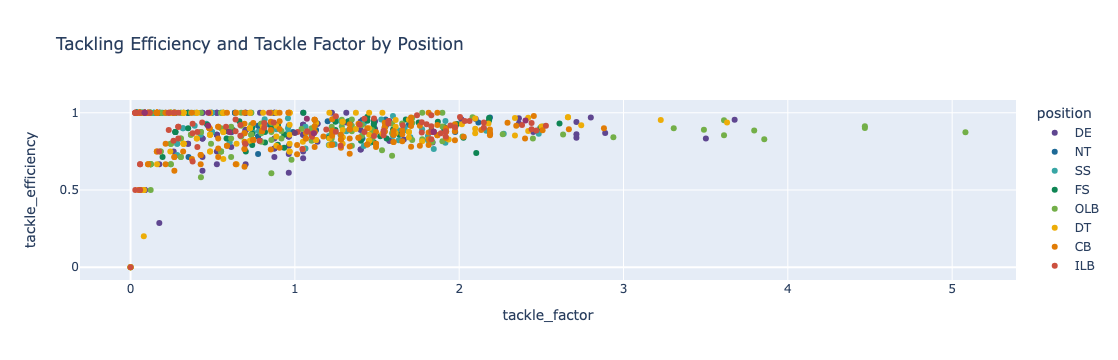

In [33]:
fig = px.scatter(player_tackles,
                 x="tackle_factor", y="tackle_efficiency", color='position',
                 hover_data=['nflId',
                            'displayName',],
                   title='Tackling Efficiency and Tackle Factor by Position',
                   color_discrete_sequence=px.colors.qualitative.Prism)
fig.show()

While the `tackle factor` may not fully correlate to efficiency, it 'is' very helpful in identifying how a defensive player performs in comparison to others who occupy the same defensive position. `OLB` players who contribute to their teams tend to generate the highest values in the `tackle factor`, with players in DE and DT taking the second and third places.

### Super Bowl 58 Predictions

Having spent the last two projects discussing the defensive proficiencies of those who remain ahead of the Big Game, it is time for me to make a prediction. To do this, I will first pull the average Away score for the 49ers (as they have been designated as the Road team) and then the average Home score for the Chiefs (as they have been designated as the Home team). The obvious caveat is that Super Bowls are often neutral site games, and Sunday's game in Las Vegas will not be an exception. 

That said, let's get the average scores.


In [35]:
agg_dict_road = {
    "min_away_score": pd.NamedAgg(column='visitorFinalScore', aggfunc='min'),
    "max_away_score": pd.NamedAgg(column='visitorFinalScore', aggfunc='max'),
    "avg_away_score": pd.NamedAgg(column='visitorFinalScore', aggfunc=np.mean)
}

agg_data = games.groupby("visitorTeamAbbr").agg(**agg_dict_road).reset_index()

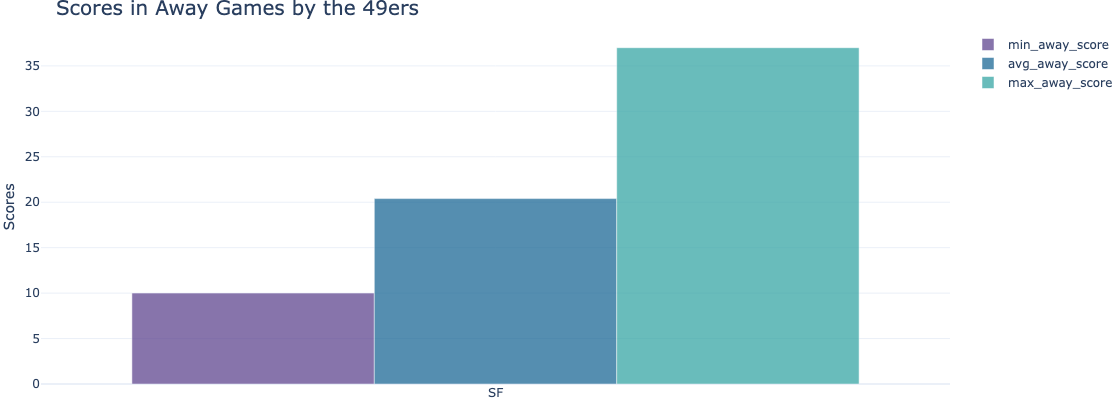

In [36]:
# Filter agg_data for the 49ers as the visitor team
sf_agg_data = agg_data[agg_data['visitorTeamAbbr'] == 'SF']

# Initialize the figure
fig = go.Figure()

# Add bars for the min, avg, and max away scores for the 49ers
fig.add_bar(x=sf_agg_data['visitorTeamAbbr'], y=sf_agg_data['min_away_score'], 
            hovertext="Minimal score in away games", name="min_away_score", 
            marker_color=px.colors.qualitative.Prism[0])  # Example color

fig.add_bar(x=sf_agg_data['visitorTeamAbbr'], y=sf_agg_data['avg_away_score'], 
            hovertext="Average score in away games", name="avg_away_score", 
            marker_color=px.colors.qualitative.Prism[1])  # Example color

fig.add_bar(x=sf_agg_data['visitorTeamAbbr'], y=sf_agg_data['max_away_score'], 
            hovertext="Maximal score in away games", name="max_away_score", 
            marker_color=px.colors.qualitative.Prism[2])  # Example color

# Update visual layout
fig.update_layout(
    showlegend=True,
    width=800,
    height=400,
    autosize=False,
    margin=dict(t=30, b=0, l=5, r=5),
    template="plotly_white",
    yaxis_title="Scores",
    title=dict(text='Scores in Away Games by the 49ers', font=dict(size=20), yref='paper')
)

# Update font size at the axes and annotations, and reduce opacity of traces
fig.update_coloraxes(colorbar_tickfont_size=10)
fig.update_annotations(font_size=12)
fig.update_traces(opacity=0.75)

# Display the figure
fig.show()

On average, the 49ers scored `20` points. While they have had games where they scored as many as 37, they had games where they scored as little as 10 points. As seen in their games leading to Super Bowl 58, the level of success San Francisco will have will heavily depend on the performance of offensive stars such as Brock Purdy, Christian McCaffrey, George Kittle, Brandon Aiyuk, and more. 

Let's now look into the Chiefs' average home scores.

In [37]:
agg_dict_home = {
    "min_home_score": pd.NamedAgg(column='homeFinalScore', aggfunc='min'),
    "max_home_score": pd.NamedAgg(column='homeFinalScore', aggfunc='max'),
    "avg_home_score": pd.NamedAgg(column='homeFinalScore', aggfunc=np.mean),

}

agg_data = games.groupby("homeTeamAbbr").agg(**agg_dict_home).reset_index()

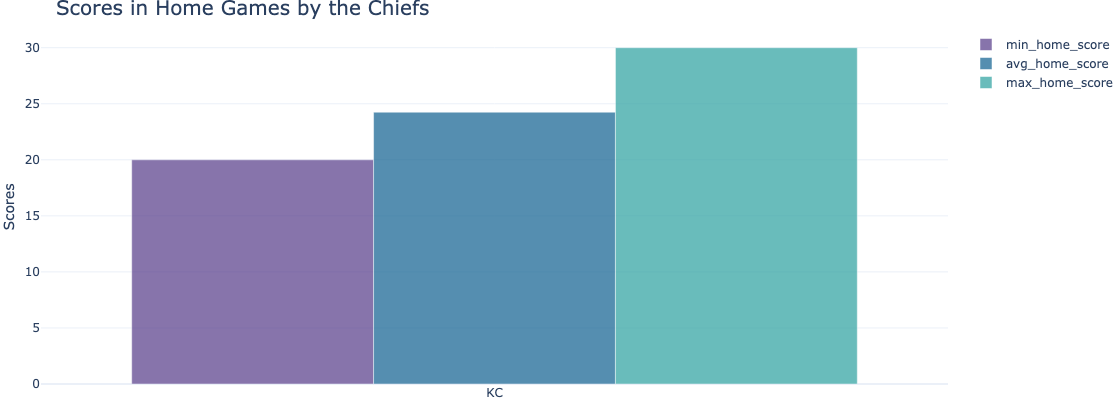

In [38]:
# Filter agg_data for the Chiefs as the home team
kc_agg_data = agg_data[agg_data['homeTeamAbbr'] == 'KC']

# Initialize the figure
fig = go.Figure()

# Add bars for the min, avg, and max home scores for the Chiefs
fig.add_bar(x=kc_agg_data['homeTeamAbbr'], y=kc_agg_data['min_home_score'], 
            hovertext="Minimal score in home games", name="min_home_score", 
            marker_color=px.colors.qualitative.Prism[0])  # Example color

fig.add_bar(x=kc_agg_data['homeTeamAbbr'], y=kc_agg_data['avg_home_score'], 
            hovertext="Average score in home games", name="avg_home_score", 
            marker_color=px.colors.qualitative.Prism[1])  # Example color

fig.add_bar(x=kc_agg_data['homeTeamAbbr'], y=kc_agg_data['max_home_score'], 
            hovertext="Maximal score in home games", name="max_home_score", 
            marker_color=px.colors.qualitative.Prism[2])  # Example color

# Update visual layout
fig.update_layout(
    showlegend=True,
    width=800,
    height=400,
    autosize=False,
    margin=dict(t=30, b=0, l=5, r=5),
    template="plotly_white",
    yaxis_title="Scores",
    title=dict(text='Scores in Home Games by the Chiefs', font=dict(size=20), yref='paper')
)

# Update font size at the axes and annotations, and reduce opacity of traces
fig.update_coloraxes(colorbar_tickfont_size=10)
fig.update_annotations(font_size=12)
fig.update_traces(opacity=0.75)

# Display the figure
fig.show()

On average, the Chiefs score about 24 points per home game. Their offense has seen fewer points scored, with a max of 30 points. However, their average score is buoyed by having a high minimum value of 20 points. This indicates that Patrick Mahomes, Travis Kelce (and Taylor Swift), and Isiah Pacheco are consistently reliable for generating leads and finding defensive holes.

Unfortunately as a 49ers fan, my data-driven prediction is: 

### San Francisco 49ers: 20 | Kansas City Chiefs: 24


But wait! There are more football analyses ahead! NFL Draft 2024 is around the corner, and we will look into which colleges generate the best defensive prospects, as well as identify teams who will most need these defensive prospects. Stay tuned!